# Vertical geometry

This workflow details how to reduce experimental data collected at the I07 beamline, when the sample is a vertical geometry (when the DCD setup is not being used).
The example data is that of a silicon wafer with some lipids material self-assembled on the surface.

The first task is to ensure that the necessary modules and packages have been imported

In [1]:
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat
import numpy as np

from islatu.refl_data import Profile, _get_iterator
from islatu.io import i07_dat_parser
from islatu.image import Image
from islatu.cropping import crop_2d
from islatu.background import fit_gaussian_1d
from os import path

## Parsing data

Once everything has been imported, we must define the files that will be reduced, in this case they are I07 `.dat` files. 
Remember that due to the changes in attenutation a full reflectometry curve typically contains 3-5 scans. In this example, five scans where performed and the files are called vrefl_1.dat to vrefl_3.dat.

In [2]:
files =['vrefl_{}.dat'.format(i) for i in range(1, 4)]

In [3]:
print(files)

['vrefl_1.dat', 'vrefl_2.dat', 'vrefl_3.dat']


This list of files is passed to the `islatu.refl_data.Profile` object, we must also inform this function what parsing function should be used. 
In this cause, as we are detailing with I07 `.dat` files, we use `islatu.io.i07_dat_parser`.
Additionally, since the motor that is to vary $q$ is an angle, we must tell the code what the `theta_axis_name` was, and the $q$ axis will be populated from this.

In [4]:
refl = Profile(files, 
               i07_dat_parser, 
               q_axis_name=None, 
               theta_axis_name='diff1halpha',
               pixel_max=2e6,
               hot_pixel_max=1e6)

100%|██████████| 163/163 [12:45<00:00,  4.69s/it] 


The `refl` object possesses a class object called `scans`, which is a list of the scan contained in the `.dat` files.

In [5]:
for i in refl.scans:
    print(i)

The file: vrefl_1.dat contains 45 images from q = 0.0149 to q = 0.1238.
The file: vrefl_2.dat contains 53 images from q = 0.1189 to q = 0.2476.
The file: vrefl_3.dat contains 163 images from q = 0.2427 to q = 0.6437.


In total, we have data ranging from $q = 0.015$ Å<sup>-1</sup> to $q = 0.64$ Å<sup>-1</sup>.

## Cropping and background subtraction

The reflectometry data is collected as a series of detector images, such as that shown below. 

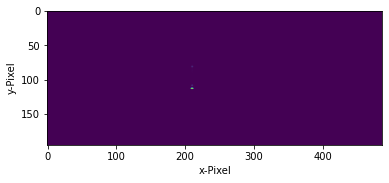

q = 0.042101465804742846 Å


In [6]:
im = Image(refl.scans[0].data['file'][11])
plt.imshow(im.n)
plt.xlabel('x-Pixel')
plt.ylabel('y-Pixel')
plt.show()
print('q = {} Å'.format(refl.scans[0].q[11].n))

This is data from around $q = 0.4$ Å<sup>-1</sup>.
The point in the middle of this image is the reflected intensity peak, that we want to measure, therefore is it necessary to crop this image down. 
This will remove the other feature that can be seen below the reflected intensity peak.

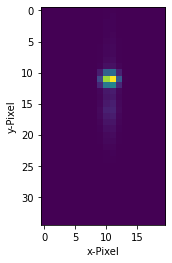

In [7]:
im.crop(crop_2d, 
        x_start=200, x_end=220, 
        y_start=70, y_end=105)
plt.imshow(im.n)
plt.xlabel('x-Pixel')
plt.ylabel('y-Pixel')
plt.show()

It is important that this peak can be seen in all images, so check that the values you have selected work for many of your images. 

Having reduced the size of the image and focused on the peak, we now need to perform a subtraction of the background signal. 
This signal can be seen if we reduce the dimensionality of the plot by summing along the y-axis of the image.

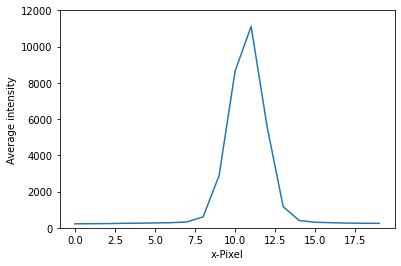

In [8]:
im = Image(refl.scans[-1].data['file'][11])
im.crop(crop_2d, 
        x_start=200, x_end=220, 
        y_start=70, y_end=105)

plt.plot(im.n.mean(axis=0))
plt.xlabel('x-Pixel')
plt.ylabel('Average intensity')
plt.ylim(0, 12000)
plt.show()

The background subtraction is performed by fitting a one-dimensional Gaussian function, with some offset from the ordinate, to the reduced dimensionality image. 
The amount by which the fit is offset from the ordinate is then subtracted from each pixel of the image.
This one-dimensional fit has been found to be more stable for vertical geometry samples.
However, investigated the [Liquid surface](./liquid_surface.html) tutorial to learn about the two-dimensional fitting option. 

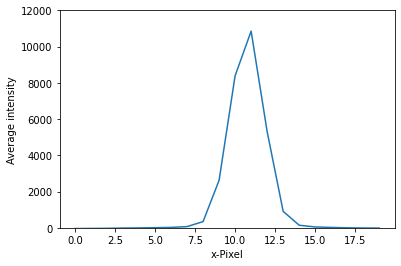

In [9]:
im.background_subtraction(fit_gaussian_1d, axis=0)
plt.plot(im.n.mean(axis=0))
plt.xlabel('x-Pixel')
plt.ylabel('Average intensity')
plt.ylim(0, 12000)
plt.show()

The background level is stored in the `image.Image` object. 

In [10]:
print(im.bkg)

260+/-8


Above, we have performed the cropping and background subtraction on a single image, a single $q$-vector. 
However, it is necessary to perform this operation on all of the images, this is achieved through the `crop` and `bkg_sub` class methods for the `refl` object. 
So to perform this process on each `.dat` file we run the following.
Notice that all of the keyword arguments are passed in dictionaries.

In [11]:
refl.crop(crop_2d, {'x_start': 200, 'x_end':220, 
                    'y_start': 70, 'y_end': 105})

100%|██████████| 163/163 [00:53<00:00,  3.04it/s]


In [12]:
refl.bkg_sub(fit_gaussian_1d, {'axis':0})

100%|██████████| 163/163 [00:29<00:00,  5.47it/s]


The width of the Gaussian resolution may be estimated from the detector image, where the value of `qz_dimension` is the axis that corresponds to $q_z$. 
Since the `fit_gaussian_1d` is performed in axis dimension `0`, the $q_z$ axis is `1`. 

In [13]:
refl.resolution_function(qz_dimension=1, progress=True)

100%|██████████| 163/163 [00:38<00:00,  4.25it/s]


## Intensity reduction

The image intensity is the summed to give the unnormalised reflected intensity, and associated uncertainties.

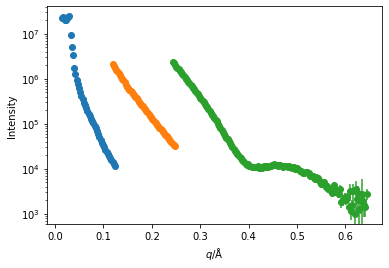

In [14]:
for s in refl.scans:
    plt.errorbar(unp.nominal_values(s.q),
                 unp.nominal_values(s.R),
                 yerr=unp.std_devs(s.R),
                 ls='',
                 marker='o')
plt.xlabel(r'$q$/Å')
plt.ylabel(r'Intensity')
plt.yscale('log')
plt.show()

The first correction is the [footprint correction](https://doi.org/10.1107/S0021889807030403) which accounts for the sample being smaller than the beam footprint (due to the shallow angle).
Where the first argument is the beam width at half maximum, and the second argument is the sample size and uncertainty. 

In [15]:
beam_width = 180e-6
sample_size = ufloat(9e-3, 1e-3)
refl.footprint_correction(beam_width, sample_size)

The final correction is he first is due to the transmission of radiation in collection. This brings the intensity of the different scans (which is different due to attenuation variances in data collection) together, to give a familiar reflectometry curve.

In [16]:
refl.transmission_normalisation()

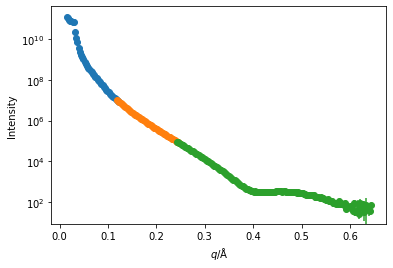

In [17]:
for s in refl.scans:
    plt.errorbar(unp.nominal_values(s.q),
                 unp.nominal_values(s.R),
                 yerr=unp.std_devs(s.R),
                 xerr=unp.std_devs(s.q),
                 ls='',
                 marker='o')
plt.xlabel(r'$q$/Å')
plt.ylabel(r'Intensity')
plt.yscale('log')
plt.show()

## Stitching and normalisation

The main reduction steps are now complete, however the scans must be brought together in a coherent dataset, normalised such that this y-axis reads the Reflectivity ($R$) (where the total external reflection is brought to $R = 1$).

In [18]:
refl.concatenate()
refl.normalise_ter()

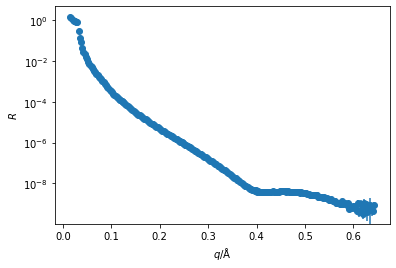

In [19]:
plt.errorbar(refl.q, refl.R, yerr=refl.dR, marker='o', ls='')
plt.xlabel(r'$q$/Å')
plt.ylabel(r'$R$')
plt.yscale('log')
plt.show()

Now, we have the option to rebin the data. The code below will rebin the data onto 100, linearly distributed points in q.

In [20]:
refl.rebin(new_q=np.linspace(refl.q.min(), refl.q.max(), 50))

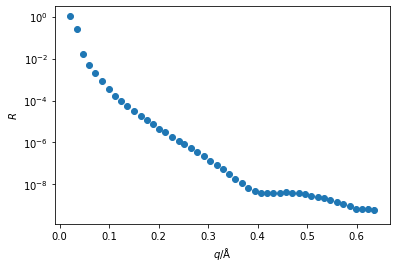

In [21]:
plt.errorbar(refl.q, refl.R, yerr=refl.dR, xerr=refl.dq, marker='o', ls='')
plt.xlabel(r'$q$/Å')
plt.ylabel(r'$R$')
plt.yscale('log')
plt.show()

The last step is to save the data, this can be achieved with the `np.savetxt` function, and will output a four column text file that can be read in to most analysis packages.
Note, that we have note defined the uncertainty in $q$ for this geometry reduction. 
Therefore, we use a resolution function of 5 % of the $q$-value. 

In [22]:
data = np.array([refl.q, refl.R, refl.dR, refl.q * 0.05]).T
np.savetxt('vrefl_reduced.txt', data, header='q R dR dq')